<a href="https://colab.research.google.com/github/kdChen07/progress-and-problems/blob/main/MSOAs_Lack_of_Vaccination_Service.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#绘制无疫苗服务MSOA地图

In [ ]:
!pip install access
!pip install logging
!pip install geopandas
!pip install mapclassify
!pip install legendgram

In [7]:
from google.colab import files

In [3]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

#导入数据

In [4]:
LA_MSOA = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/LA_MSOA_code.csv')
LA_MSOA

,LA_Code_2020,LA_name_2020,MSOA Code
0,E06000001,Hartlepool,E02002483
1,E06000001,Hartlepool,E02002484
2,E06000001,Hartlepool,E02002485
3,E06000001,Hartlepool,E02002487
4,E06000001,Hartlepool,E02002488
...,...,...,...
6786,E09000033,Westminster,E02000979
6787,E09000033,Westminster,E02000980
6788,E09000033,Westminster,E02000981
6789,E09000033,Westminster,E02000982


# 获取MSOA边界数据

In [5]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

In [6]:
MSOA

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18..."
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18..."
2,E02000003,Barking and Dagenham 002,8062,1272,886,575,301,78,11174,"POLYGON ((548956.371 189063.484, 549087.474 18..."
3,E02000004,Barking and Dagenham 003,4401,866,598,444,262,116,6687,"POLYGON ((551945.701 186027.855, 551672.764 18..."
4,E02000005,Barking and Dagenham 004,7982,1144,629,413,211,53,10432,"POLYGON ((549420.553 187442.648, 548985.314 18..."
...,...,...,...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,7425,741,473,305,167,16,9127,"POLYGON ((540585.068 178133.897, 540368.424 17..."
6787,E02006931,Greenwich 038,7267,1024,672,510,255,78,9806,"POLYGON ((538775.968 177841.277, 539072.243 17..."
6788,E02006932,Liverpool 060,16963,264,173,80,25,10,17515,"POLYGON ((335757.632 390987.474, 335739.219 39..."
6789,E02006933,Liverpool 061,7130,603,485,220,97,4,8539,"POLYGON ((335096.788 389638.891, 334715.024 38..."


#获取MSOA点数据

In [8]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

In [9]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (445582.345 524175.434)
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (446777.151 524256.841)
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (461356.929 515118.900)
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (446117.027 525455.836)
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (461053.212 516175.379)
...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (393469.114 227500.260)
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (332829.367 109219.836)
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (343276.340 158947.520)
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (331710.269 136880.200)


## 读取已有疫苗站数据

In [10]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

#读取疫苗站与MSOA之间驾驶距离数据

In [32]:
distance_cost_df = pd.read_csv('https://github.com/kdChen07/progress-and-problems/blob/main/distance555158.csv?raw=true')
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

,cost,origin,dest
0,6712.7,E02002536,122
1,13881.2,E02002536,127
2,13631.4,E02002536,137
3,12395.5,E02002536,836
4,12641.2,E02002536,838
...,...,...,...
555153,18589.3,E02003088,1204
555154,8207.2,E02006070,1278
555155,20694.9,E02006679,1176
555156,11732.4,E02006679,1177


# 计算10英里内无疫苗服务的MSOA

In [23]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

In [24]:
MSOA_with_supply

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,MSOA,MSOA_with_supply
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",E02000001,True
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",E02000002,True
2,E02000003,Barking and Dagenham 002,8062,1272,886,575,301,78,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",E02000003,True
3,E02000004,Barking and Dagenham 003,4401,866,598,444,262,116,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",E02000004,True
4,E02000005,Barking and Dagenham 004,7982,1144,629,413,211,53,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",E02000005,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,7425,741,473,305,167,16,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",E02006930,True
6787,E02006931,Greenwich 038,7267,1024,672,510,255,78,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",E02006931,True
6788,E02006932,Liverpool 060,16963,264,173,80,25,10,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",E02006932,True
6789,E02006933,Liverpool 061,7130,603,485,220,97,4,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",E02006933,True


### Count the number of MSOAs that are lack of vaccination service

In [26]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are 383 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [27]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

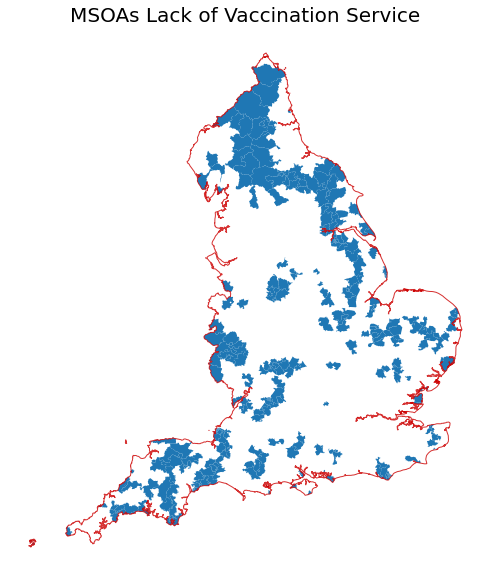

In [28]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})